# Node and Edge Embeddings - Using GNN

In [53]:
import pickle
import torch
import networkx as nx
import torch.nn as nn
import matplotlib.pyplot as plt
from functions import AMLDataPreprocessing
import torch
import torch.nn as nn
from torch_geometric.nn import MessagePassing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc

![Screenshot 2024-05-23 at 21.28.02.png](<attachment:Screenshot 2024-05-23 at 21.28.02.png>)
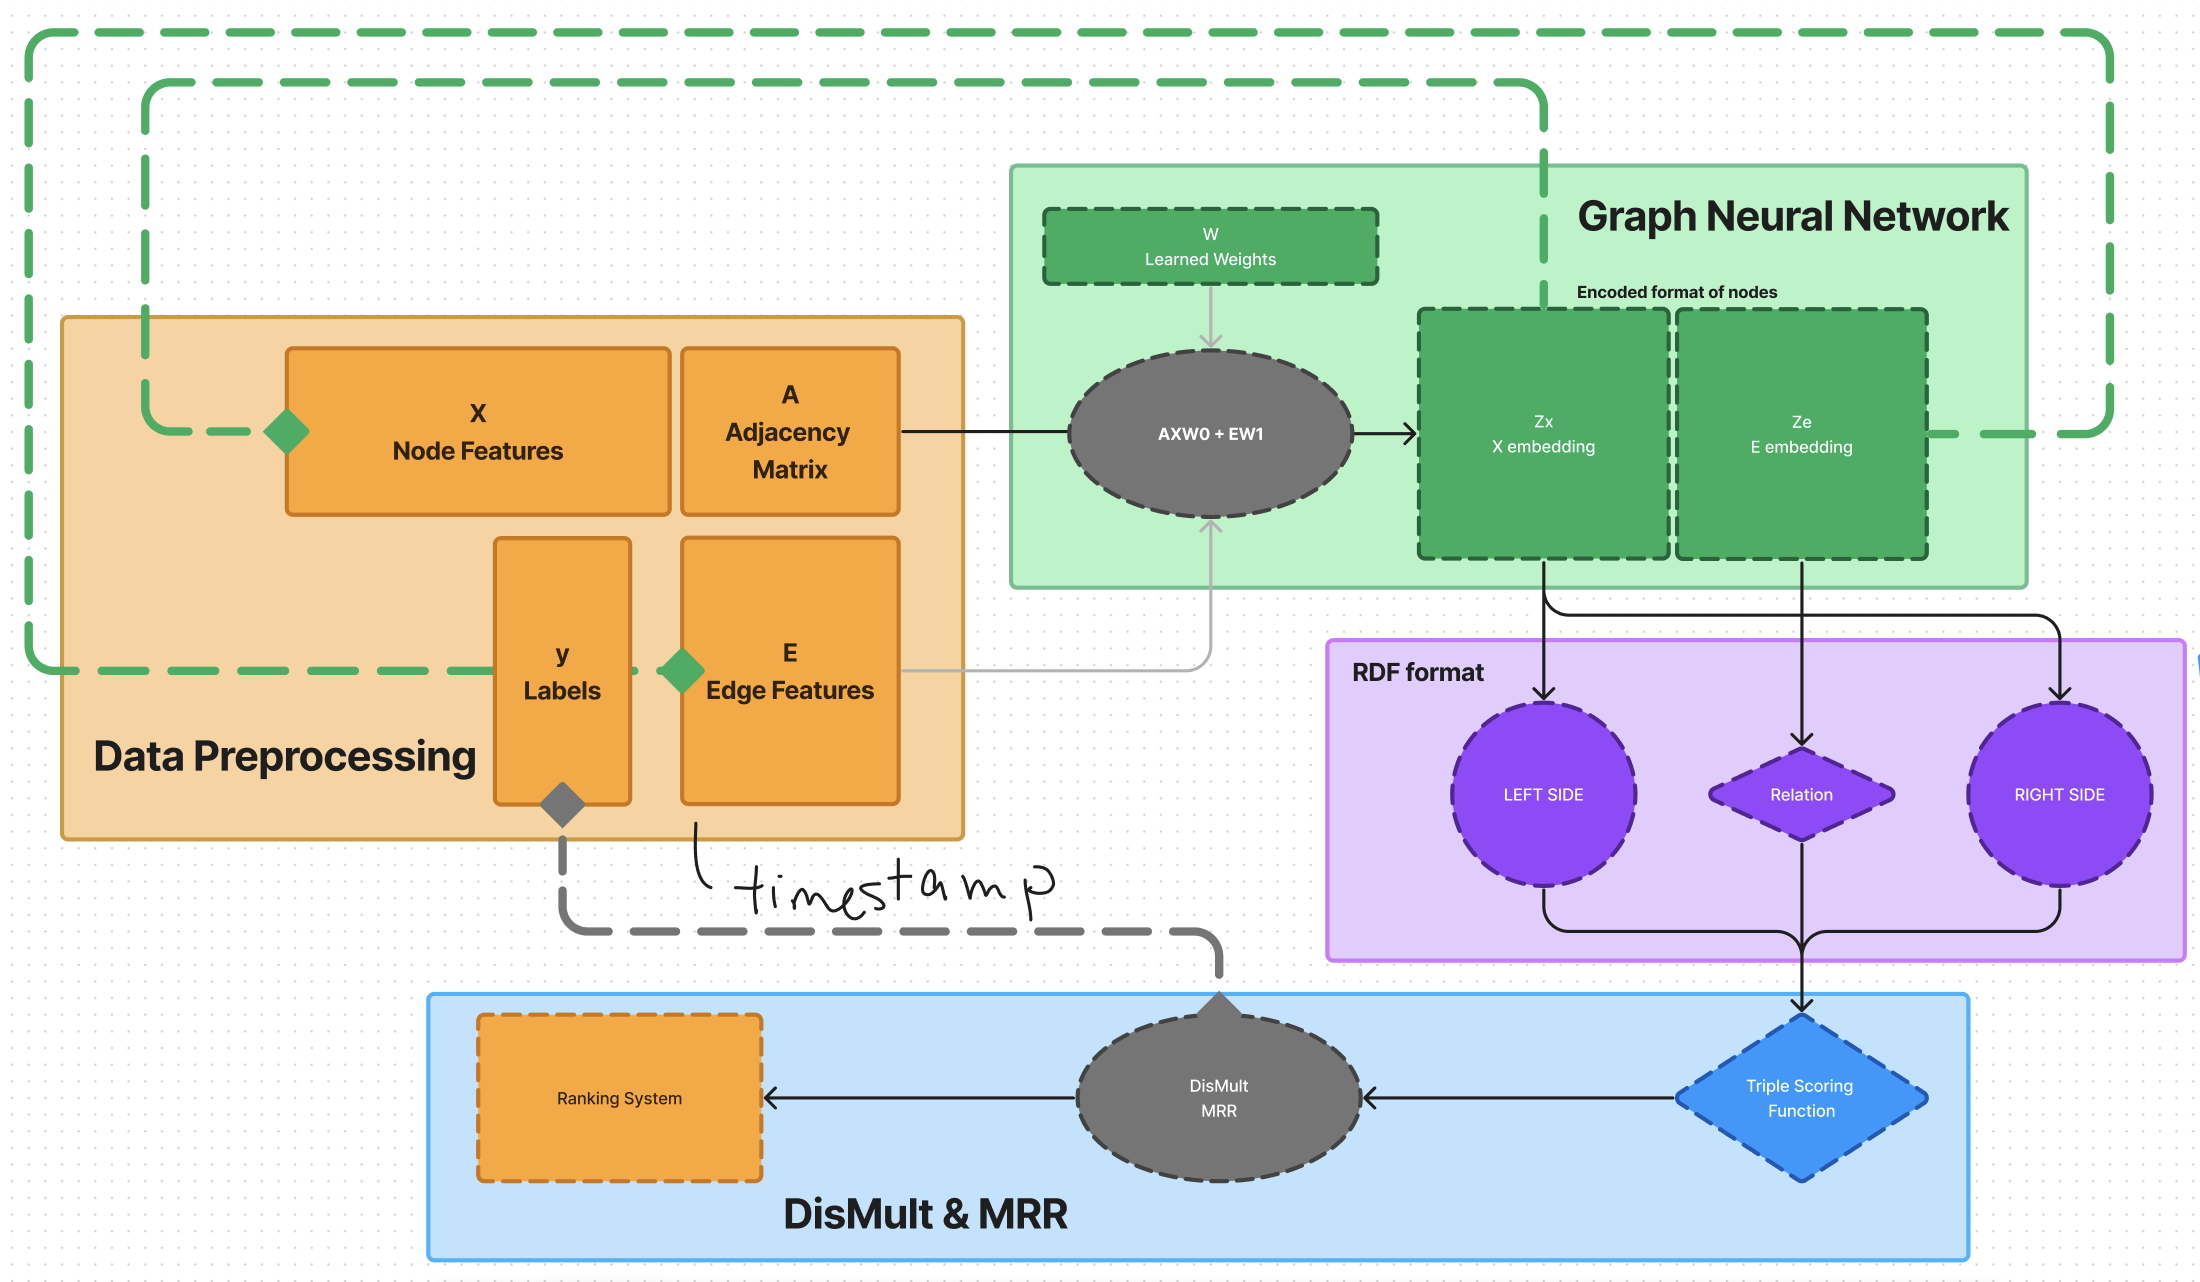

# LOADING GRAPH from Jupyter Notebook 
\(only use if not using Class Preprocessor)

Data Head - <bound method NDFrame.head of              Timestamp  From Bank    Account  To Bank  Account.1  \
0     2022/09/01 00:12      47640  811D69990    47640  811D69990   
1     2022/09/14 12:37      19329  808B1C350     1412  809F49D20   
2     2022/09/03 11:29      17769  8128ED040   223240  8128E8980   
3     2022/09/09 18:44      11899  80532AFB0    29620  80AE51B90   
4     2022/09/04 04:40      27444  80B3BFFD0    11405  80B3D2700   
...                ...        ...        ...      ...        ...   
9995  2022/09/08 09:49      31149  80EB13650    15447  80E0555C0   
9996  2022/09/09 19:44       1362  8001E3BE0     1467  8003F4070   
9997  2022/09/03 00:07     146167  812A57E10    23885  80224DF50   
9998  2022/09/11 17:22       1292  800DF7070        1  8019C00E0   
9999  2022/09/05 09:05         12  800499810    21611  8016625C0   

      Amount Received Receiving Currency  Amount Paid   Payment Currency  \
0               12.57          US Dollar        12.57          US

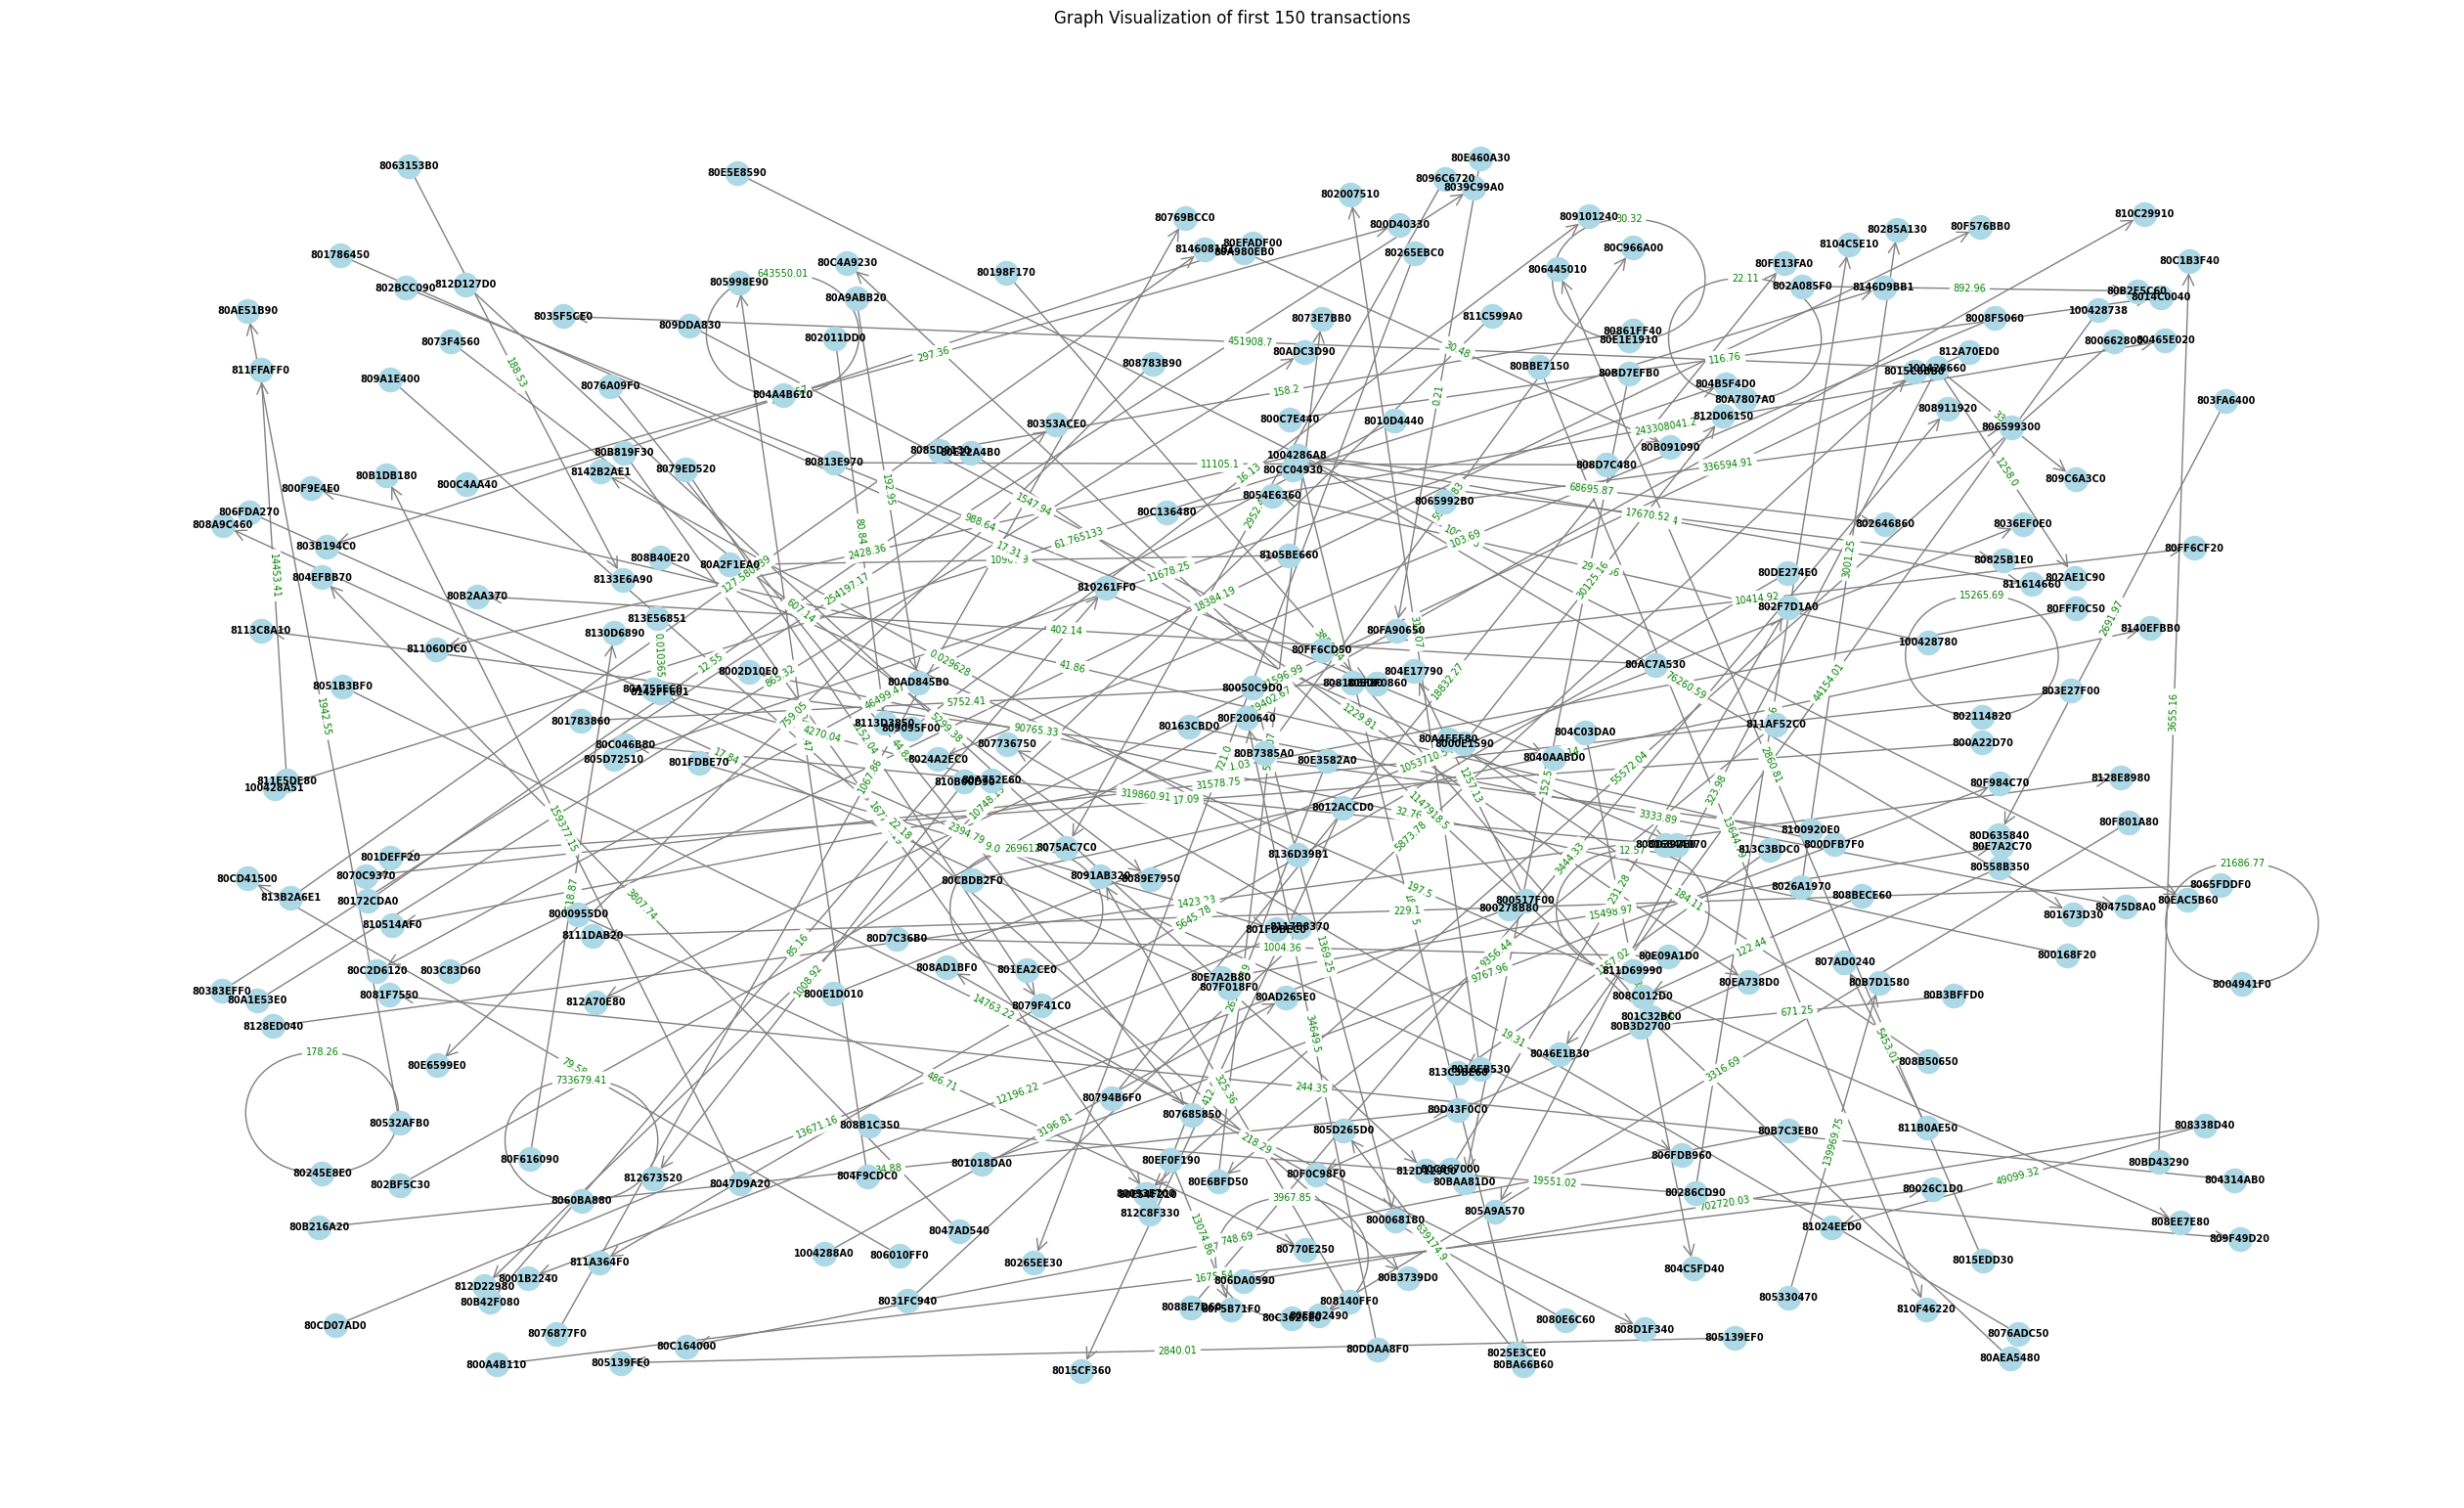

In [54]:
filename = '/Users/owhy/Documents/Datasets/HI-Small_Trans_balanced.csv'
# Create an instance of the AMLDataPreprocessing class
data_preprocessor = AMLDataPreprocessing(filename)
# Process the data
input_data, graph_full, x, y, labels, links, edges_amount, node_features, edges_features = data_preprocessor.process_data()
# Visualize
visual = data_preprocessor.visualize_graph(links, edges_amount)

adjacency_matrix = torch.from_numpy(nx.adjacency_matrix(graph_full).todense()).to(torch.float)

# PROCESS DATA directly

## Save the data

In [55]:
with open("graph.pickle", "wb") as f:
    pickle.dump({
        'edges_features': edges_features,
        'links': links,
        'labels': labels,
        'graph_full': graph_full,
        'adjacency_matrix': adjacency_matrix,
        'visual': visual,
        'node_features': node_features,
        'x': x,
        'y': y,
        'labels': labels,
        'input_data': input_data
    }, f)


In [56]:
input_data

Data(x=[15899, 44], edge_index=[2, 10000], edge_attr=[10000, 40], y=[10000])

In [57]:
input_data.edge_attr.size()

torch.Size([10000, 40])

In [58]:
labels.size()

torch.Size([10000])

In [59]:
input_data.x.size()

torch.Size([15899, 44])

In [60]:
node_features.size()

torch.Size([15899, 44])

In [61]:
adjacency_matrix.size()

torch.Size([15899, 15899])

In [62]:
# Split the nodes into training, validation, and test sets
num_edges = edges_features.shape[0]
indices = list(range(num_edges))
print(indices)
train_indices, test_val_indices = train_test_split(indices, test_size=0.4, stratify=labels)
val_indices, test_indices = train_test_split(test_val_indices, test_size=0.5, stratify=labels[test_val_indices])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [63]:
# Create masks
train_mask = torch.tensor([i in train_indices for i in range(num_edges)], dtype=torch.bool)
val_mask = torch.tensor([i in val_indices for i in range(num_edges)], dtype=torch.bool)
test_mask = torch.tensor([i in test_indices for i in range(num_edges)], dtype=torch.bool)

# GRAPH NEURAL NETWORKS

In [64]:
class GNNLayer(MessagePassing):
    def __init__(self, node_features, edge_features, hidden_channels):
        super(GNNLayer, self).__init__(aggr='add')
        self.node_features = node_features
        self.edge_features = edge_features
        self.hidden_channels = hidden_channels
        
        # Learnable parameters
        self.weight_node = nn.Parameter(torch.Tensor(node_features, hidden_channels))
        self.weight_edge = nn.Parameter(torch.Tensor(edge_features, hidden_channels))
        self.reset_parameters()
        
    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight_node)
        nn.init.xavier_uniform_(self.weight_edge)
        
    def forward(self, x, edge_index, edge_attr):
        # AXW0 + EW1
        global adjacency_matrix
        self.adjacency_matrix = adjacency_matrix

        # print(x.size())
        # print(self.adjacency_matrix.size())
        # print(self.weight_node.size())
        
        axw = torch.matmul(self.adjacency_matrix, x) @ self.weight_node
        ew = torch.matmul(edge_attr, self.weight_edge)

        return axw, ew

    def update(self, aggr_out):
        return aggr_out

In [65]:
class GNNModel(nn.Module):
    def __init__(self, node_features, edge_features, hidden_channels, out_channels):
        super(GNNModel, self).__init__()
        self.conv1 = GNNLayer(node_features, edge_features, hidden_channels)

        # self.threshold = nn.Parameter(torch.tensor([0.5]))  # Trainable threshold parameter
    
    def forward(self, x, edge_index, edge_attr):
        axw1, ew1 = self.conv1(x, edge_index, edge_attr)

        head_indices, tail_indices = self.mapping(ew1, edge_index)
        scores = self.dismult(axw1, ew1, head_indices, tail_indices)
        
        return axw1, ew1, scores # returning x and e embeddings

    def update_edge_attr(self, edge_attr, new_channels):
        num_edge_features = edge_attr.size(1)
        if new_channels > num_edge_features:
            updated_edge_attr = torch.cat((edge_attr, torch.zeros((edge_attr.size(0), new_channels - num_edge_features), device=edge_attr.device)), dim=1)
        else:
            updated_edge_attr = edge_attr[:, :new_channels]
        return updated_edge_attr
    
    def dismult(self, axw, ew, head_indices, tail_indices):
        scores = []
        heads = []
        tails = []
        relations = []
        for i in range(ew.size()[0]): # going through all triples
            head = axw[head_indices[i]]
            tail = axw[tail_indices[i]]
            relation = ew[i]
            heads.append(head)
            tails.append(tail)
            relations.append(relation)
            raw_score = torch.sum(head * relation * tail, dim=-1)
            normalized_score = torch.sigmoid(raw_score)  # Apply sigmoid activation
            scores.append(raw_score) # calc scores
        scores = torch.stack(scores)
        return scores
    
    def mapping(self, ew, edge_index):
        head_indices = []
        tail_indices = []
        for c in range(ew.size()[0]): # getting all indices
            head_index = edge_index[0][c]
            tail_index = edge_index[1][c]
            head_indices.append(head_index)
            tail_indices.append(tail_index)
        
        return head_indices, tail_indices

In [66]:
learning_rate = 0.001
hidden_channels = 25
out_channels = 15

model = GNNModel(node_features=input_data.x.size(1), edge_features=input_data.edge_attr.size(1), hidden_channels=hidden_channels, out_channels=out_channels)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss()  # Binary classification loss

In [67]:
def train(data):
    model.train()
    optimizer.zero_grad()
    x_embedding, e_embedding, scores = model(data.x, data.edge_index[:, train_mask], data.edge_attr[train_mask])

    loss = criterion(scores, labels[train_mask].float())
    loss.backward()
    optimizer.step()
    
    return loss.item(), x_embedding, e_embedding, scores

# Validation function
def validate(data):
    model.eval()
    with torch.no_grad():
        x_embedding, e_embedding, scores = model(data.x, data.edge_index[:, val_mask], data.edge_attr[val_mask])
        val_loss = criterion(scores, labels[val_mask].float()).item()
    return x_embedding, e_embedding, scores, val_loss

# Test function
def test(data):
    model.eval()
    with torch.no_grad():
        x_embedding, e_embedding, scores = model(data.x, data.edge_index[:, test_mask], data.edge_attr[test_mask])
        test_loss = criterion(scores, labels[test_mask].float()).item()
    return x_embedding, e_embedding, scores, test_loss

In [68]:
# Continue training loop from provided script
epochs = 100
losses = []
val_losses = []
best_val_loss = float('inf')
patience = 10

all_x_embeddings = []
all_e_embeddings = []

for epoch in range(epochs):
    loss, x_embedding, e_embedding, scores = train(input_data)
    val_x_embedding, val_e_embedding, val_scores, val_loss = validate(input_data)

    losses.append(loss)
    val_losses.append(val_loss)

    all_x_embeddings.append(x_embedding.detach().cpu().numpy())
    all_e_embeddings.append(e_embedding.detach().cpu().numpy())
    # print(f"This is Fraudulent - {scores[8000]}")
    # print(f"This is Not fraudulent - {scores[2000]}")
    print(f"Epoch {epoch}, Training Loss: {loss}, Validation Loss: {val_loss}")

    # EARLY STOPPING CHECK # TODO create margin of improvement instead of just looking at if loss is improving.
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the model if validation loss improves
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        patience_counter += 1
        if patience_counter > patience:
            print(f"Validation loss hasn't improved for {patience} epochs. Early stopping...")
            break

Epoch 0, Training Loss: 0.9037424325942993, Validation Loss: 0.8957027792930603
Epoch 1, Training Loss: 0.8728036284446716, Validation Loss: 0.8708497285842896
Epoch 2, Training Loss: 0.8433392643928528, Validation Loss: 0.8479012250900269
Epoch 3, Training Loss: 0.8154357671737671, Validation Loss: 0.8268567323684692
Epoch 4, Training Loss: 0.7922788262367249, Validation Loss: 0.807602047920227
Epoch 5, Training Loss: 0.772165060043335, Validation Loss: 0.790291965007782
Epoch 6, Training Loss: 0.7538929581642151, Validation Loss: 0.7748414278030396
Epoch 7, Training Loss: 0.7369110584259033, Validation Loss: 0.7610002160072327
Epoch 8, Training Loss: 0.7209653854370117, Validation Loss: 0.7486442923545837
Epoch 9, Training Loss: 0.7063159942626953, Validation Loss: 0.7376918196678162
Epoch 10, Training Loss: 0.6933884024620056, Validation Loss: 0.7279016971588135
Epoch 11, Training Loss: 0.6813933253288269, Validation Loss: 0.7190526127815247
Epoch 12, Training Loss: 0.67026466131210

In [72]:
val_scores.size()

torch.Size([2000])

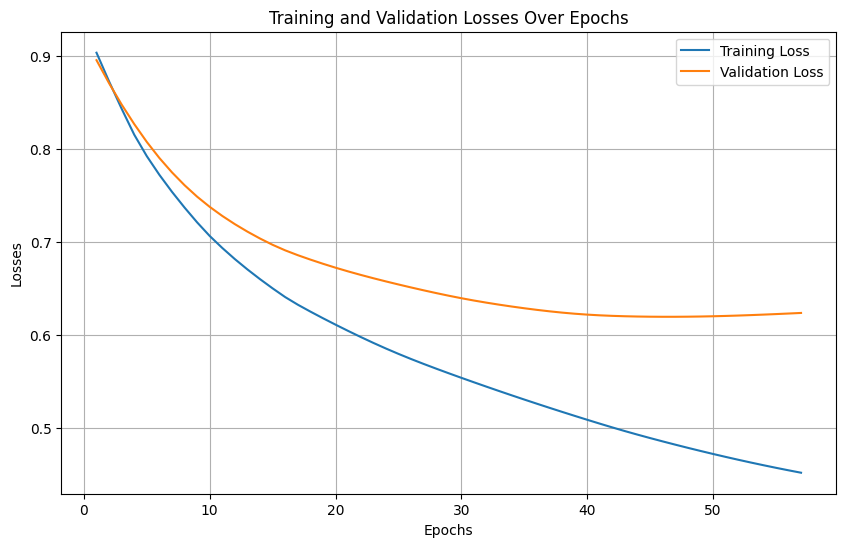

In [73]:
# Plot
epoch_numbers = list(range(1, len(losses) + 1))

plt.figure(figsize=(10, 6))
plt.plot(epoch_numbers, losses, label="Training Loss")
plt.plot(epoch_numbers, val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Training and Validation Losses Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [74]:
# MRR --> rank, top y scores are 1s, rest is 0s --> predictions created

with torch.no_grad():
    # scores = model(heads, relations, tails).squeeze()
    sorted_indices = torch.argsort(val_scores, descending=True)
    true_indices = sorted_indices[:torch.sum(labels[val_mask].float()).int()]  # Select top predictions based on number of positive labels
    predictions = torch.zeros(len(labels[val_mask].float()))
    predictions[true_indices] = 1
    mrr = 0
    for i, idx in enumerate(true_indices):
        if labels[idx].item() == 1:
            mrr = 1 / (i + 1)  # MRR calculation
            break
    print("Mean Reciprocal Rank (MRR):", mrr)

Mean Reciprocal Rank (MRR): 1.0


In [75]:
predictions.size()

torch.Size([2000])

In [76]:
labels[val_mask].float().size()

torch.Size([2000])

In [77]:
def evaluate_model(predictions, true_values):
    # Convert tensors to numpy arrays
    predictions = predictions.cpu().numpy()
    true_values = true_values.cpu().numpy()
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(true_values, predictions)
    precision = precision_score(true_values, predictions)
    recall = recall_score(true_values, predictions)
    f1 = f1_score(true_values, predictions)
    cm = confusion_matrix(true_values, predictions)
    classification_rep = classification_report(true_values, predictions)
    
    # ROC Curve and AUC if applicable
    try:
        fpr, tpr, thresholds = roc_curve(true_values, predictions)
        roc_auc = auc(fpr, tpr)
    except ValueError:
        fpr, tpr, roc_auc = None, None, None
    
    metrics_dict = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Confusion Matrix": cm,
        "Classification Report": classification_rep,
        "ROC Curve": (fpr, tpr, roc_auc)
    }
    
    return metrics_dict


In [79]:
metrics_dict = evaluate_model(predictions, labels[val_mask].float())

# Print Evaluation Metrics
print("Evaluation Metrics:")
print("-------------------\n")
for metric_name, metric_value in metrics_dict.items():
    if metric_name == "Confusion Matrix":
        print("Confusion Matrix:")
        print(metric_value)
    elif metric_name == "Classification Report":
        print("Classification Report:")
        print(metric_value)
    elif metric_name == "ROC Curve":
        fpr, tpr, roc_auc = metric_value
        print("ROC Curve:")
        print("- False Positive Rate:", fpr)
        print("- True Positive Rate:", tpr)
        print("- AUC:", roc_auc)
    else:
        print(f"{metric_name}: {metric_value}")
    print()

Evaluation Metrics:
-------------------

Accuracy: 0.844

Precision: 0.74

Recall: 0.74

F1 Score: 0.74

Confusion Matrix:
[[1244  156]
 [ 156  444]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89      1400
         1.0       0.74      0.74      0.74       600

    accuracy                           0.84      2000
   macro avg       0.81      0.81      0.81      2000
weighted avg       0.84      0.84      0.84      2000


ROC Curve:
- False Positive Rate: [0.         0.11142857 1.        ]
- True Positive Rate: [0.   0.74 1.  ]
- AUC: 0.8142857142857143



# Save in RDF format

In [ ]:
import gzip
import torch

def save_embeddings_as_triples(edge_index, node_embeddings, edge_embeddings, file_path):
    with gzip.open(file_path, 'wt') as f:
        for i in range(edge_index.size(1)):
            head_index = edge_index[0, i].item()
            tail_index = edge_index[1, i].item()
            head_uri = f"http://example.org/node/{head_index}"
            tail_uri = f"http://example.org/node/{tail_index}"
            relation_uri = f"http://example.org/relation/{i}"

            # Write connectedTo triple
            f.write(f'<{head_uri}> <http://example.org/ontology#connectedTo> <{tail_uri}>\n')
            
            # Write head node embedding triple
            head_embedding = node_embeddings[head_index].numpy()
            head_str = ' '.join(map(str, head_embedding))
            f.write(f'<{head_uri}> <http://example.org/ontology#hasEmbedding> "{head_str}"\n')
            
            # Write tail node embedding triple
            tail_embedding = node_embeddings[tail_index].numpy()
            tail_str = ' '.join(map(str, tail_embedding))
            f.write(f'<{tail_uri}> <http://example.org/ontology#hasEmbedding> "{tail_str}"\n')
            
            # Write edge embedding triple
            relation_embedding = edge_embeddings[i].numpy()
            relation_str = ' '.join(map(str, relation_embedding))
            f.write(f'<{relation_uri}> <http://example.org/ontology#hasEmbedding> "{relation_str}"\n')

# Example usage after training
x_embeddings = torch.tensor(all_x_embeddings[-1])  # Use the last epoch's embeddings
e_embeddings = torch.tensor(all_e_embeddings[-1])  # Use the last epoch's embeddings

save_embeddings_as_triples(input_data.edge_index, x_embeddings, e_embeddings, 'embeddings.nt.gz')


In [ ]:
import gzip

def print_rdf_triples(file_path):
    # counter = 0
    with gzip.open(file_path, 'rt') as f:
        counter = 0
        for line in f:
            print(line.strip())
            counter += 1
    print(counter)

# Replace 'embeddings.nt.gz' with the actual file path
print_rdf_triples("embeddings.nt.gz") # CONNECTED TO --> HAS EMBEDDING
# print(4999*4)

In [ ]:
def evaluate_reconstruction(x_embeddings, e_embeddings, model, input_data):
    model.eval()
    reconstructed_x = model.decoder_x(torch.tensor(x_embeddings).to(input_data.x.device))
    reconstructed_e = model.decoder_e(torch.tensor(e_embeddings).to(input_data.edge_attr.device))
    
    mse_loss = nn.MSELoss()
    loss_x = mse_loss(reconstructed_x, input_data.x)
    loss_e = mse_loss(reconstructed_e, input_data.edge_attr)
    
    return loss_x.item(), loss_e.item()

loss_x, loss_e = evaluate_reconstruction(all_x_embeddings[-1], all_e_embeddings[-1], model, input_data)
print(f'Reconstruction Loss for Node Features: {loss_x}')
print(f'Reconstruction Loss for Edge Features: {loss_e}')

In [ ]:
with open("embeddings.pickle", "wb") as f:
    pickle.dump({
        'x_embeddings': x_embeddings,
        'e_embeddings': e_embeddings
    }, f)